In [1]:
#Imports
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# I - Influenza H1N1 2009 Sweden

### Preliminary part

In [2]:
#Generate k-regular graph with n nodes 
def create_graph(n,k):
    ind = [x for x in range(-k//2,k//2+1) if x!=0]
    G = nx.Graph()
    for i in range(n):
        edges = [(i,(i+j)%n) for j in ind]
        G.add_edges_from(edges)
    return G

In [3]:
def sim_epidemic(G,I,beta,rho,w):
    k = G.degree(0)
    n = len(G)
    pop = [{'S':0,'I':0,'R':0}]
    newi = [0 for _ in range(w)]

    for i in range(n):#Set some nodes to infected
        if i in I:
            G.nodes[i]['state'] = 'I'
            pop[0]['I'] += 1
        else:
            G.nodes[i]['state'] = 'S'
            pop[0]['S'] += 1
    
    
    for x in range(w):
        p = pop[x].copy()
        next_states = {}

        for i in range(n):#Compute next state of each node
            if G.nodes[i]['state'] == 'S':
                neighbour_states = [G.nodes[j]['state'] for j in list(G[i].keys())]
                m = neighbour_states.count('I')
                if np.random.random()>(1-beta)**m:
                    next_states[i] = 'I'
                    p['S'] -= 1
                    p['I'] += 1
                    newi[x] += 1 

            elif G.nodes[i]['state'] == 'I':
                if np.random.random()<rho:
                    next_states[i] = 'R'
                    p['I'] -= 1
                    p['R'] += 1
        nx.set_node_attributes(G,next_states,'state')#Update node states
        pop.append(p)
    
    return pop,newi

Infected nodes: [460 269 375 116 430   4 248 166 207 246]


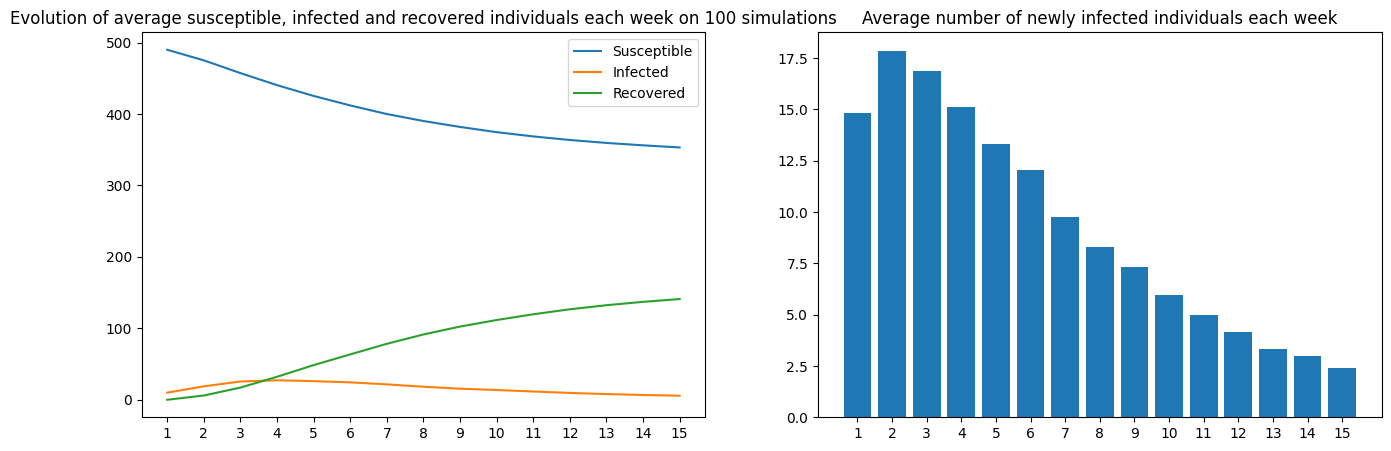

In [4]:
def sim_results(G,i=10,w=15,N=100,beta=0.25,rho=0.6):
    infected = np.random.choice(len(G),i,False)
    print('Infected nodes:',infected)
    n = np.zeros(w)
    s,i,r = np.zeros(w),np.zeros(w),np.zeros(w)
    for _ in range(N):
        x,y = sim_epidemic(G,infected,beta,rho,w)
        n += y
        s += [x[i]['S'] for i in range(w)]
        i += [x[i]['I'] for i in range(w)]
        r += [x[i]['R'] for i in range(w)]
    fig,ax = plt.subplots(1,2,figsize=(16,5))
    ax[0].plot(range(1,w+1),s/N,label='Susceptible')
    ax[0].plot(range(1,w+1),i/N,label='Infected')
    ax[0].plot(range(1,w+1),r/N,label='Recovered')
    ax[0].set_xticks(range(1,w+1))
    ax[0].legend()
    ax[0].set_title('Evolution of average susceptible, infected and recovered individuals each week on '+str(N)+' simulations')
    ax[1].bar(range(1,w+1),n/N)
    ax[1].set_xticks(range(1,w+1))
    ax[1].set_title('Average number of newly infected individuals each week')
    plt.show()


G = create_graph(500,6)
sim_results(G)

In [5]:
def add_random_links(G,c):#Adds new node to G with c random links to existing nodes chosen proportionnaly to their degree
    l = len(G)
    deg = np.array([x[1] for x in G.degree()])
    p = deg/np.sum(deg)
    linked = np.random.choice(range(l),c,False,p)
    new_edges = [(l,x) for x in linked]
    G.add_edges_from(new_edges)


def generate_random_graph(n,k):
    G = nx.complete_graph(k+1)
    if k%2 == 0:
        c = k//2
        while len(G)!=n:
            add_random_links(G,c)
    else:
        while len(G) != n:
            if len(G)%2 == 0:
                add_random_links(G,k//2)
            else:
                add_random_links(G,k//2+1)

    return G
    

In [6]:
G = generate_random_graph(1500,7)
print("Average degree of the graph's nodes:",np.mean([x[1] for x in G.degree()]))

Average degree of the graph's nodes: 7.0


### Pandemic without vaccination

Infected nodes: [ 22 406  95 408 377 214  84 300 398 342]


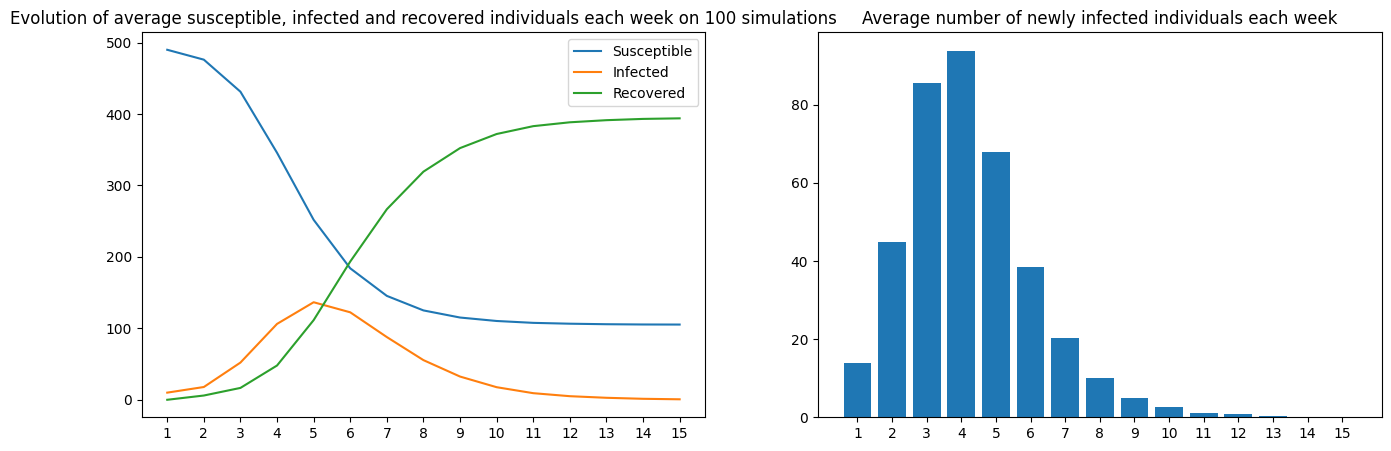

In [7]:
G = generate_random_graph(500,6)
sim_results(G)

### Pandemic with vaccination

In [8]:
def sim_epidemic_with_vaccination(G,I,beta,rho,w,vaccines):
    k = G.degree(0)
    n = len(G)
    pop = [{'S':0,'I':0,'R':0}]
    newi = [0 for _ in range(w)]
    not_vacc = [i for i in range(n)]
    v = [0]+vaccines

    for i in range(n):#Set some nodes to infected
        if i in I:
            G.nodes[i]['state'] = 'I'
            pop[0]['I'] += 1
        else:
            G.nodes[i]['state'] = 'S'
            pop[0]['S'] += 1

    
    for x in range(w):
        p = pop[x].copy()
        next_states = {}
        quant = (v[x+1]-v[x])*n//100

        for i in range(quant):#Give vaccines to non vaccinated individuals
            new = np.random.choice(not_vacc)
            not_vacc.remove(new)
            p[G.nodes[new]['state']] -= 1
            G.nodes[new]['state'] = 'V'

    
        for i in range(n):#Compute next state of each node
            if G.nodes[i]['state'] == 'S':
                neighbour_states = [G.nodes[j]['state'] for j in list(G[i].keys())]
                m = neighbour_states.count('I')
                if np.random.random()>(1-beta)**m:
                    next_states[i] = 'I'
                    p['S'] -= 1
                    p['I'] += 1
                    newi[x] += 1 

            elif G.nodes[i]['state'] == 'I':
                if np.random.random()<rho:
                    next_states[i] = 'R'
                    p['I'] -= 1
                    p['R'] += 1
        nx.set_node_attributes(G,next_states,'state')#Update node states
        pop.append(p)
    
    return pop,newi

Infected nodes: [416   1 493 283 488 404 456 381 408 106]


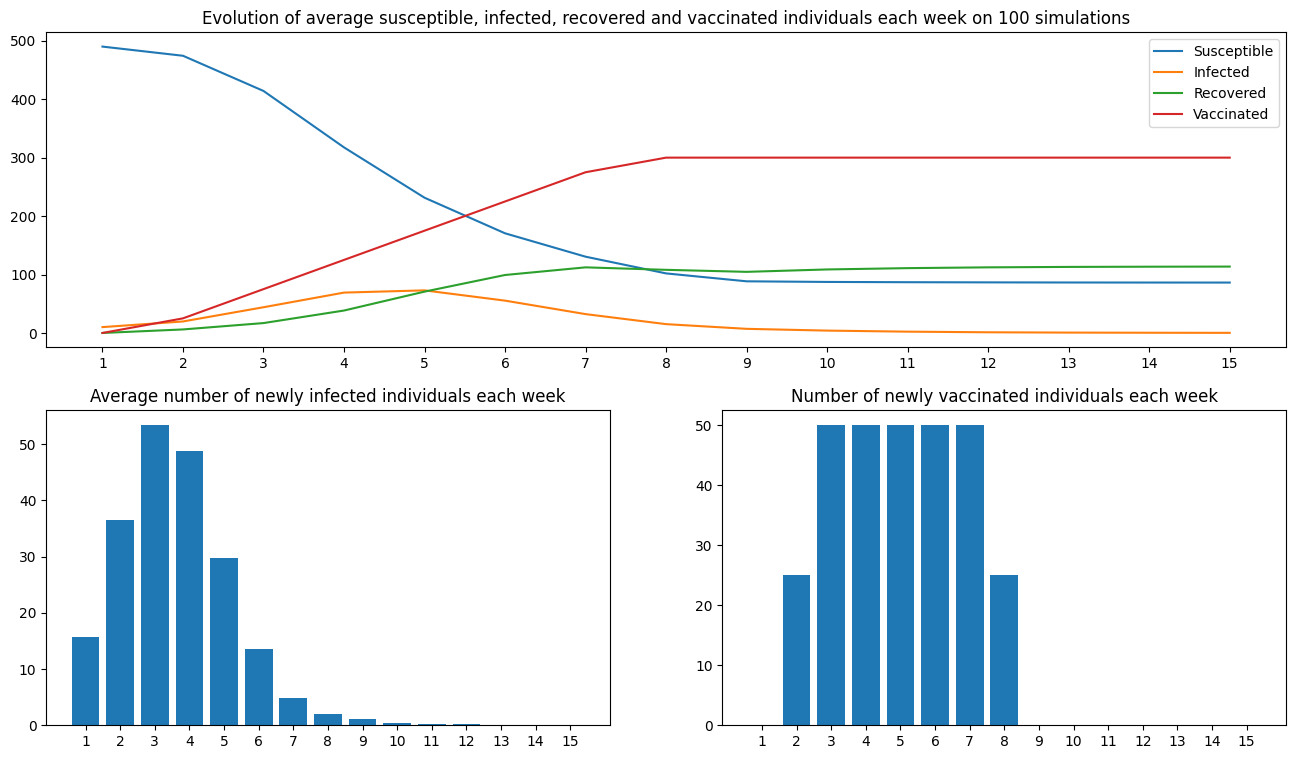

In [17]:
def sim_results_with_vaccination(G,vaccines,i=10,w=15,N=100,beta=0.25,rho=0.6):
    n = len(G)
    infected = np.random.choice(n,i,False)
    print('Infected nodes:',infected)
    ni = np.zeros(w)
    s,i,r = np.zeros(w),np.zeros(w),np.zeros(w)
    v = n//100*np.array(vaccines)
    for _ in range(N):
        x,y = sim_epidemic_with_vaccination(G,infected,beta,rho,w,vaccines)
        ni += y
        s += [x[i]['S'] for i in range(w)]
        i += [x[i]['I'] for i in range(w)]
        r += [x[i]['R'] for i in range(w)]

    nv = [vaccines[0]*n//100]+[(vaccines[i+1]-vaccines[i])*n//100 for i in range(w-1)]

    fig = plt.figure(figsize=(16,9))
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0,:])
    ax2 = fig.add_subplot(gs[1,0])
    ax3 = fig.add_subplot(gs[1,1])

    ax1.plot(range(1,w+1),s/N,label='Susceptible')
    ax1.plot(range(1,w+1),i/N,label='Infected')
    ax1.plot(range(1,w+1),r/N,label='Recovered')
    ax1.plot(range(1,w+1),v,label='Vaccinated')
    ax1.set_xticks(range(1,w+1))
    ax1.legend()
    ax1.set_title('Evolution of average susceptible, infected, recovered and vaccinated individuals each week on '+str(N)+' simulations')
    ax2.bar(range(1,w+1),ni/N)
    ax2.set_xticks(range(1,w+1))
    ax2.set_title('Average number of newly infected individuals each week')
    ax3.bar(range(1,w+1),nv)
    ax3.set_xticks(range(1,w+1))
    ax3.set_title('Number of newly vaccinated individuals each week')
    
    plt.show()

G = generate_random_graph(500,6)
vaccines = [0,5,15,25,35,45,55,60,60,60,60,60,60,60,60]
sim_results_with_vaccination(G,vaccines)

### H1N1 Pandemic in Sweden 2009

In [44]:
vaccines = [5,9,16,24,32,40,47,54,59,60,60,60,60,60,60]
n = 934
I0 = [1,1,3,5,9,17,32,32,17,5,2,1,0,0,0,0]
k0 = 10
b0 = 0.3
r0 = 0.6
dk = 1
db = 0.1
dr = 0.1

def parameter_search(n,vaccines,I0,k0=k0,dk=dk,b0=b0,db=db,r0=r0,dr=dr,N=100,w=15,e = float('inf')):
    min_error = e
    best_k = k0
    best_b = b0
    best_r = r0
    i = I0[0]

    for k in [k0-dk,k0,k0+dk]:
        for b in [b0-db,b0,b0+db]:
            for r in [r0-dr,r0,r0+dr]:
                G = generate_random_graph(n,k)
                infected = np.random.choice(n,i,False)
                new_infected = np.zeros(w)
                for _ in range(N):
                    _,y = sim_epidemic_with_vaccination(G,infected,b,r,w,vaccines)
                    new_infected += y
                new_infected = np.array(new_infected)/N

                error = np.sqrt(np.sum((new_infected-I0[1:])**2)/w)
                if error < min_error:
                    print('Updating parameters k =',k,', b =',b,' r =',r,' error =',error)
                    min_error = error
                    best_k = k
                    best_b = b
                    best_r = r
    print('Checked all parameters for this iteration')
    if np.abs(best_k-k0)<1e-8 and np.abs(best_b-b0)<1e-8 and np.abs(best_r-r0)<1e-8:
        return k0,b0,r0
    else:
        return parameter_search(n,vaccines,I0,best_k,dk,best_b,db,best_r,dr,N,w,min_error)

In [45]:
k,beta,rho = parameter_search(n,vaccines,I0)
print(k,beta,rho)

Updating parameters k = 9 , b = 0.19999999999999998  r = 0.5  error = 4.212410236432344
Checked all parameters for this iteration
Checked all parameters for this iteration
9 0.19999999999999998 0.5


In [46]:
k,beta,rho = parameter_search(n,vaccines,I0,k0=k,dk=dk,b0=beta,db=db/2,r0=rho,dr=dr/2,e=5)
print(k,beta,rho)

Updating parameters k = 8 , b = 0.19999999999999998  r = 0.45  error = 4.888048008493097
Updating parameters k = 8 , b = 0.19999999999999998  r = 0.5  error = 4.816608073461379
Updating parameters k = 8 , b = 0.19999999999999998  r = 0.55  error = 4.506748273422867
Updating parameters k = 9 , b = 0.19999999999999998  r = 0.5  error = 3.9593938930093837
Checked all parameters for this iteration
9 0.19999999999999998 0.5


Infected nodes: [827]


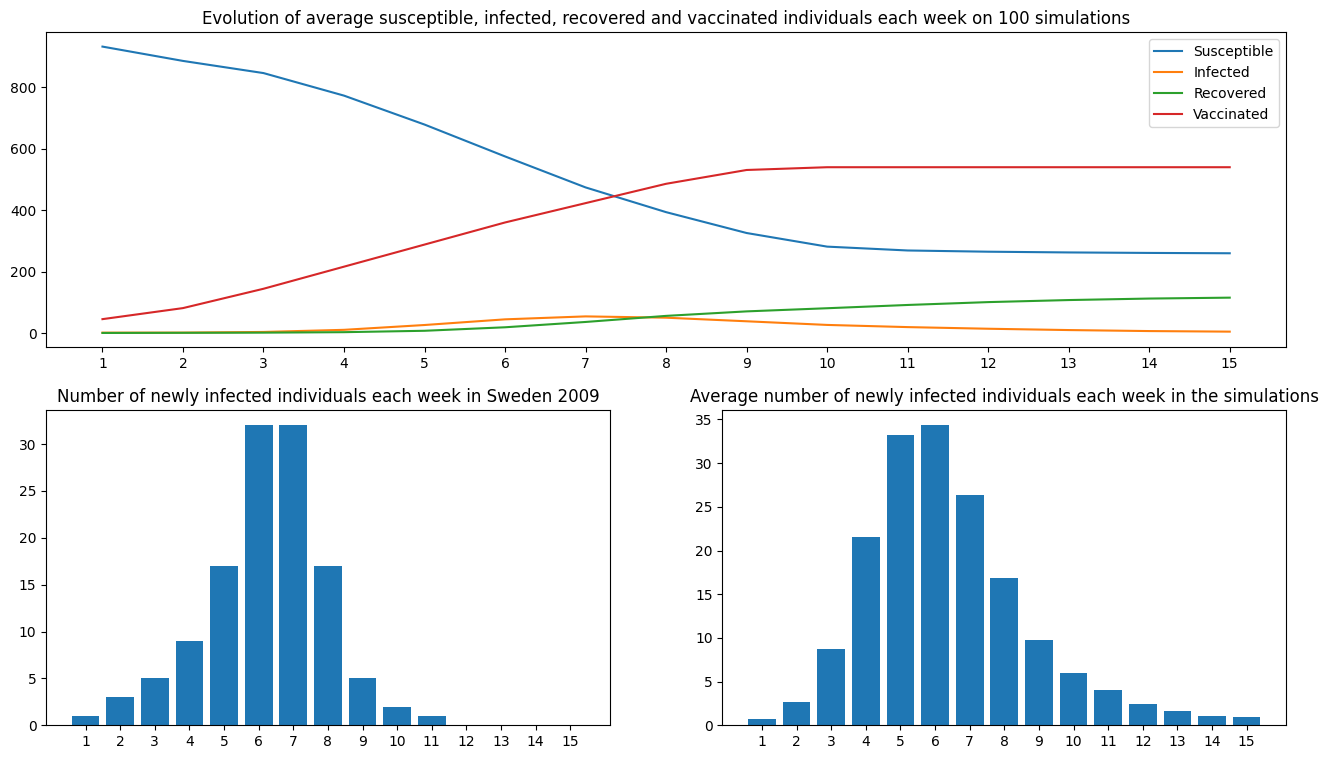

In [48]:
G = generate_random_graph(n,k)
w=15
N=100


infected = np.random.choice(n,I0[0],False)
print('Infected nodes:',infected)
ni = np.zeros(w)
s,i,r = np.zeros(w),np.zeros(w),np.zeros(w)
v = n//100*np.array(vaccines)
for _ in range(N):
    x,y = sim_epidemic_with_vaccination(G,infected,beta,rho,w,vaccines)
    ni += y
    s += [x[i]['S'] for i in range(w)]
    i += [x[i]['I'] for i in range(w)]
    r += [x[i]['R'] for i in range(w)]

fig = plt.figure(figsize=(16,9))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])

ax1.plot(range(1,w+1),s/N,label='Susceptible')
ax1.plot(range(1,w+1),i/N,label='Infected')
ax1.plot(range(1,w+1),r/N,label='Recovered')
ax1.plot(range(1,w+1),v,label='Vaccinated')
ax1.set_xticks(range(1,w+1))
ax1.legend()
ax1.set_title('Evolution of average susceptible, infected, recovered and vaccinated individuals each week on '+str(N)+' simulations')
ax2.bar(range(1,w+1),I0[1:])
ax2.set_xticks(range(1,w+1))
ax2.set_title('Number of newly infected individuals each week in Sweden 2009')
ax3.bar(range(1,w+1),ni/N)
ax3.set_xticks(range(1,w+1))
ax3.set_title('Average number of newly infected individuals each week in the simulations')

plt.show()

# II- Coloring

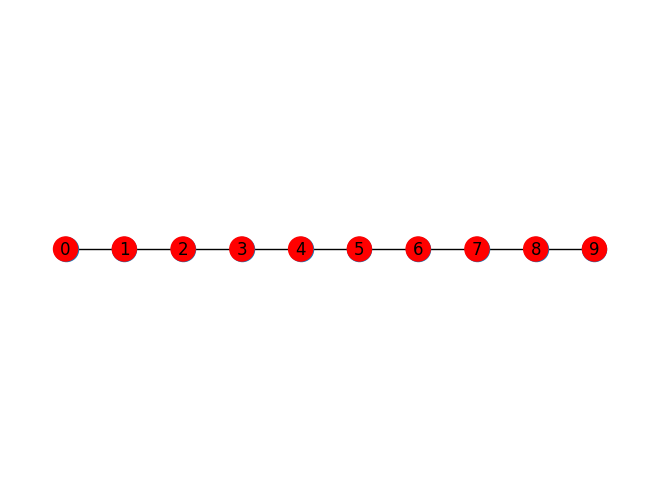

In [49]:
G = nx.Graph()
G.add_edges_from([(i,i+1) for i in range(9)])
colors = ['red' for _ in range(10)]
pos = {i:(i,0) for i in range(10)}
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_nodes(G,pos,node_color=colors)

In [50]:
def cost(a,b):
    return int(a==b)

def inv_noise(t):
    return t/50

def potential(A,colors):
    n = len(A)
    u = 0
    for i in range(n):
        ci = colors[i]
        c = [cost(ci,colors[j]) for j in range(n)]
        u += A[i]@c
    return 1/2*u

In [51]:
def coloring(colors_init,colors,A,cost,inv_noise):
    n = len(A)
    u = potential(A,colors_init)
    pot=[u]
    col = colors_init.copy()
    t = 1
    while u > 1e-8:
        i = np.random.choice(n)#Choose random node
        p = []
        for c in colors:#Compute probability of each new color
            costs = [cost(c,col[j]) for j in range(n)]
            p.append(np.exp(-inv_noise(t)*A[i]@costs))
        p = p/np.sum(p)
        col[i] = np.random.choice(colors,p=p)#Choose new color
        u = potential(A,col)
        pot.append(u)
        t += 1
    return col,pot 

In [52]:
A=nx.adjacency_matrix(G).toarray()
new_colors,potentials = coloring(colors,['red','green'],A,cost,inv_noise)

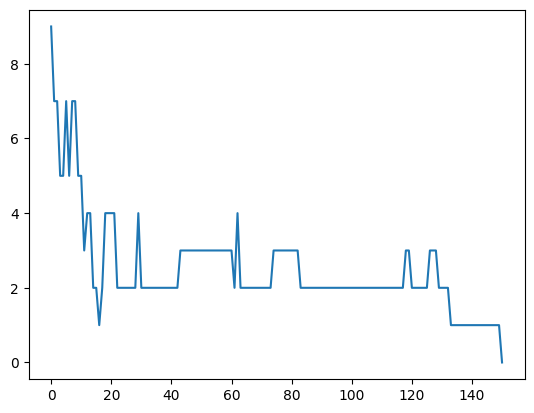

In [53]:
plt.plot(potentials)
plt.show()

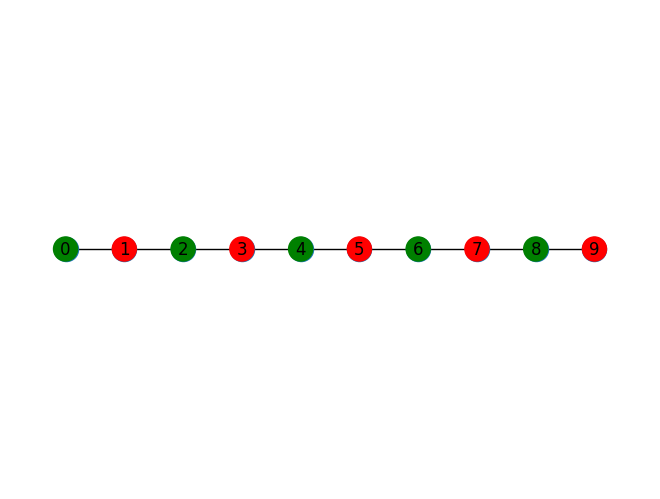

In [54]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_nodes(G,pos,node_color=new_colors)

In [55]:
from scipy.io import loadmat

In [56]:
coords = loadmat('coords.mat')['coords']
#print(coords)
wifi = loadmat('wifi.mat')['wifi']
#print(wifi)

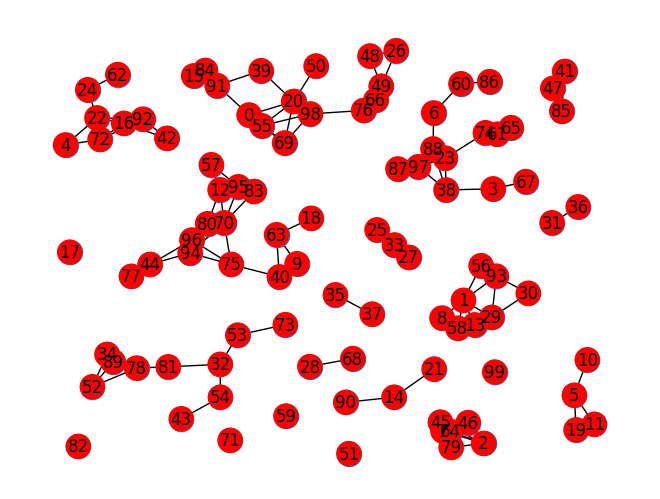

In [57]:
G = nx.from_numpy_array(wifi)
n = len(coords)
pos = {i:coords[i] for i in range(n)}
colors = {1:'red',2:'green',3:'blue',4:'yellow',5:'magenta',6:'cyan',7:'white',8:'black'}
colors_init = [1 for _ in range(n)]
colormap = [colors[colors_init[i]] for i in range(n)]
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_nodes(G,pos,node_color=colormap)

In [58]:
def cost2(a,b):
    if a==b:
        return 2
    elif abs(a-b)==1:
        return 1
    else:
        return 0

In [59]:
print(list(colors.keys()))

[1, 2, 3, 4, 5, 6, 7, 8]


In [60]:
new_colors,potentials = coloring(colors_init,list(colors.keys()),wifi,cost2,inv_noise)

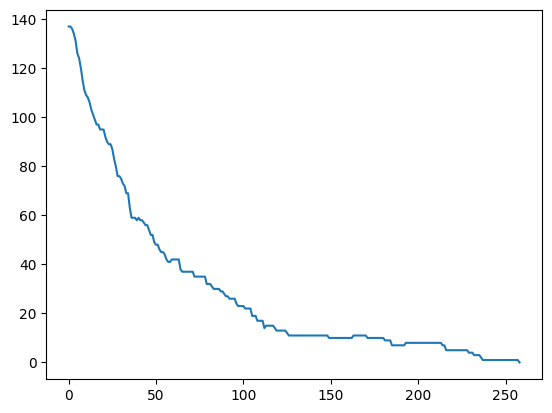

In [61]:
plt.plot(potentials)
plt.show()

['magenta', 'red', 'red', 'green', 'red', 'blue', 'black', 'blue', 'black', 'red', 'white', 'white', 'black', 'magenta', 'green', 'green', 'magenta', 'red', 'yellow', 'cyan', 'red', 'cyan', 'green', 'blue', 'black', 'red', 'red', 'cyan', 'black', 'white', 'black', 'yellow', 'blue', 'black', 'red', 'magenta', 'red', 'green', 'black', 'cyan', 'cyan', 'blue', 'red', 'blue', 'red', 'black', 'yellow', 'black', 'magenta', 'white', 'yellow', 'blue', 'black', 'cyan', 'red', 'black', 'cyan', 'cyan', 'blue', 'black', 'blue', 'green', 'green', 'black', 'white', 'cyan', 'blue', 'yellow', 'blue', 'blue', 'cyan', 'black', 'white', 'blue', 'black', 'red', 'red', 'cyan', 'cyan', 'magenta', 'red', 'red', 'black', 'red', 'cyan', 'red', 'white', 'black', 'magenta', 'yellow', 'white', 'yellow', 'yellow', 'yellow', 'blue', 'yellow', 'black', 'red', 'magenta', 'black']


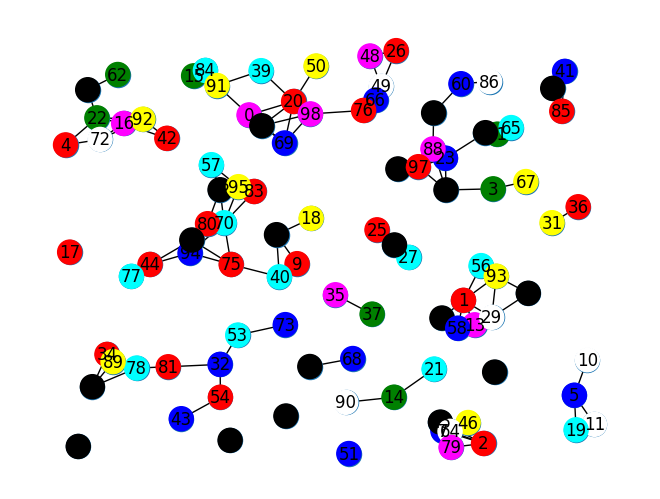

In [62]:
colormap = [colors[new_colors[i]] for i in range(n)]
print(colormap)
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_nodes(G,pos,node_color=colormap)

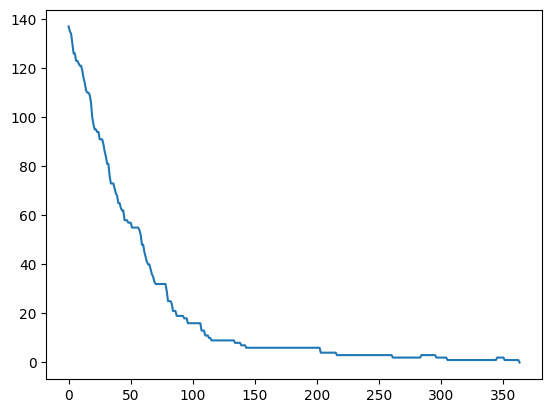

['cyan', 'black', 'green', 'blue', 'red', 'white', 'red', 'white', 'red', 'magenta', 'blue', 'green', 'black', 'blue', 'magenta', 'white', 'red', 'red', 'magenta', 'yellow', 'blue', 'green', 'blue', 'black', 'cyan', 'blue', 'red', 'black', 'blue', 'magenta', 'black', 'green', 'blue', 'magenta', 'black', 'yellow', 'white', 'green', 'red', 'magenta', 'black', 'black', 'black', 'blue', 'red', 'red', 'yellow', 'red', 'cyan', 'blue', 'red', 'green', 'cyan', 'black', 'black', 'black', 'cyan', 'cyan', 'white', 'white', 'blue', 'red', 'red', 'blue', 'black', 'cyan', 'magenta', 'white', 'red', 'red', 'white', 'black', 'white', 'magenta', 'blue', 'red', 'black', 'white', 'red', 'cyan', 'magenta', 'magenta', 'green', 'magenta', 'red', 'yellow', 'black', 'red', 'blue', 'yellow', 'blue', 'blue', 'magenta', 'green', 'blue', 'blue', 'black', 'cyan', 'magenta', 'white']
0.0


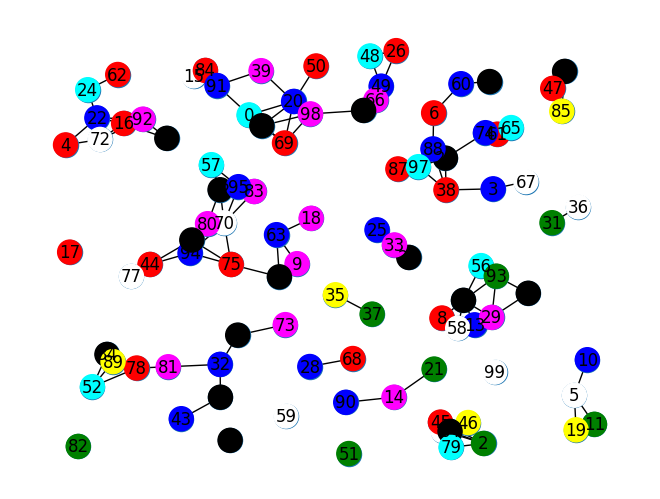

In [77]:
def inv_noise2(t):
    return 10

new_colors,potentials = coloring(colors_init,list(colors.keys()),wifi,cost2,inv_noise2)
plt.plot(potentials)
plt.show()
colormap = [colors[new_colors[i]] for i in range(n)]
print(colormap)
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_nodes(G,pos,node_color=colormap)
print(potentials[-1])